In [0]:
from google.colab import drive # access data in Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# from tensorboardcolab import *
# tbc = TensorBoardColab()

In [0]:
#@title Imports {display-mode: "form"}
# This code will be hidden when the notebook is loaded.

%%capture

%matplotlib inline

import os # os specific actions
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # image processing
import matplotlib.pyplot as plt # plots
from sklearn.model_selection import train_test_split # machine learning

# deep learning framework
import keras.backend as K
from keras import utils
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import *

!pip install pydensecrf
from pydensecrf.utils import unary_from_labels
import pydensecrf.densecrf as dcrf
from tqdm import tqdm

np.set_printoptions(suppress=True)
%precision 3
pd.options.display.float_format = '{:.3f}'.format


# %cd /content/gdrive/My\ Drive/Liver_Segmentation
# !ls *.py
# from modelFuncs import *
# from testFuncs import *

In [0]:
dir_to_save = '2Channels'

numOfSlices = 1
numOfChannels = 2

retrain = False
initial_epoch = 0  # Relevant only if retrain is True


batchSize = 2
numOfEpochs = 30

In [0]:
#@title Input data acquisition {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

fullLiver = False  # Full liver (created by) Liver+lesion # STEP 1 in 2-STEPS-MODEL
if numOfChannels == 1:
  onlyLiver = False  # False means only lesion
  multLiver = False   # Find lesions from liver only # STEP 2 in 2-STEPS-MODEL

if retrain is False:
  initial_epoch = 0

numOfBatches = 'full'

  
input_size=(512, 512, numOfSlices)

# log file
log_file_name = dir_to_save + '_training.log'
log_file_path = '/content/gdrive/My Drive/Liver_Segmentation/logs/' + dir_to_save
log_file_full = os.path.join(log_file_path, log_file_name)
if not os.path.exists(log_file_path):
  os.makedirs(log_file_path)
csv_logger = CSVLogger(log_file_full, append=False)

# WEIGHTS_LIB = '/content/gdrive/My Drive/Liver_Segmentation/Weights'
weightsfilename = '/' + str(initial_epoch) + '.hdf5'
weightsPath = log_file_path + weightsfilename


DATA_LIB = '/content/gdrive/My Drive/Liver_Segmentation/dataForGenerator/'

if numOfSlices == 3:
  IMAGE_LIB_TRAIN = DATA_LIB + 'ct_train_3slice/'
  MASK_LIB_TRAIN = DATA_LIB + 'seg_train_3slice/'

  IMAGE_LIB_VAL = DATA_LIB + 'ct_val_3slice/'
  MASK_LIB_VAL = DATA_LIB + 'seg_val_3slice/'
  
  numOfFiles_train = 1076 
  numOfFiles_val = 494 


elif numOfSlices == 1:
  IMAGE_LIB_TRAIN = DATA_LIB + 'ct_train/'
  MASK_LIB_TRAIN = DATA_LIB + 'seg_train/'

  IMAGE_LIB_VAL = DATA_LIB + 'ct_val/'
  MASK_LIB_VAL = DATA_LIB + 'seg_val/'
  
  numOfFiles_train = 1092 
  numOfFiles_val = 500 
  
if numOfBatches == 'full':
  numOfBatchesVal = int(numOfFiles_val / batchSize)
  numOfBatchesTrain = int(numOfFiles_train / batchSize)
else:
  numOfBatchesVal = numOfBatches
  numOfBatchesTrain = numOfBatches

SEED=int(np.random.randint(1,100))

In [0]:
#@title Model functions definitions {display-mode: "form"}

# This code will be hidden when the notebook is loaded.
def my_generator(IMAGE_LIB, MASK_LIB, do_resize=False):
  
    SEED = 42
        
    if do_resize is False:
      IMG_WIDTH = 512
      IMG_HEIGHT = 512
    else:
      IMG_WIDTH = 256
      IMG_HEIGHT = 256
    if numOfSlices == 3:
      color_mode = 'rgb'
    elif numOfSlices == 1:
      color_mode = 'grayscale'

    data_gen_args = dict(rotation_range=4,
                         width_shift_range=0.08,
                         height_shift_range=0.08,
                         zoom_range=0.05)

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        IMAGE_LIB,
        class_mode=None,
        batch_size=batchSize,
        color_mode = color_mode,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        seed=SEED)

    mask_generator = mask_datagen.flow_from_directory(
        MASK_LIB,
        batch_size=batchSize,
        color_mode="grayscale",
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        seed=SEED)

    while True:
      x_batch = image_generator.next()  # (bs, 512, 512, 1)
      y_batch = mask_generator.next()[0]  # (bs, 512, 512, 3)

      ## preprocess images in batch
      x_data = np.empty((batchSize, IMG_HEIGHT, IMG_WIDTH, numOfSlices), dtype='float32')
      y_data = np.empty((batchSize, IMG_HEIGHT, IMG_WIDTH, numOfChannels), dtype='float32')

      for i in range(len(x_batch)):

        # normalize ct images
        im = x_batch[i, :, :, :]
        if do_resize:              
          im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
        im = (im - np.min(im)) / (np.max(im) - np.min(im))  # Normalization between 0-1
        x_data[i, :, :, :] = im

        # normalize mask images
        im = y_batch[i, :, :, 0]
        if do_resize:
          im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)

        liver = (im > 85) & (im <= 170)
        lesion = im > 170

        if numOfChannels == 1:
          if onlyLiver is True:
            if fullLiver is True:
              y_data[i, :, :, 0] = liver + lesion
            else:
              y_data[i, :, :, 0] = liver
                           
          else:  # onlyLesion
            y_data[i, :, :, 0] = lesion
            if multLiver is True:
              x_data[i, :, :, 0]  =  x_data[i, :, :, 0] * (liver + lesion)
            

        if numOfChannels == 2:
          if fullLiver is True:
            y_data[i, :, :, 0] = liver + lesion
            y_data[i, :, :, 1] = lesion
          else:
            y_data[i, :, :, 0] = liver
            y_data[i, :, :, 1] = lesion

      x_batch = x_data
      y_batch = y_data

      yield x_batch, y_batch



def unet(do_batchnorm=True, do_dropout=True):
    input_layer = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(input_layer)
    if do_batchnorm:
        conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    if do_batchnorm:
        conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    if do_dropout:
        pool1 = Dropout(0.5)(pool1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    if do_batchnorm:
        conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    if do_batchnorm:
        conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    if do_dropout:
        pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    if do_batchnorm:
        conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    if do_batchnorm:
        conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    if do_dropout:
        pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    if do_batchnorm:
        conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    if do_batchnorm:
        conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    if do_dropout:
        pool4 = Dropout(0.5)(pool4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    if do_batchnorm:
        conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    if do_batchnorm:
        conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    if do_batchnorm:
        conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    if do_batchnorm:
        conv6 = BatchNormalization()(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    if do_batchnorm:
        conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    if do_batchnorm:
        conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    if do_batchnorm:
        conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    if do_batchnorm:
        conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    if do_batchnorm:
        conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    if do_batchnorm:
        conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    if do_batchnorm:
        conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(numOfChannels, 1, activation='sigmoid')(conv9)

    model = Model(inputs=input_layer, outputs=conv10)

    return model


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)  # K is keras.backend
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())


def precision(y_true, y_pred):  # PPV - Positive Predictive Value
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + K.epsilon()) / (K.sum(y_pred_f) + K.epsilon())


def tversky_index(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    tp = K.sum(y_true_f * y_pred_f)  # True positives
    fp = K.sum(y_pred_f) - tp  # False positives
    fn = K.sum(y_true_f) - tp  # False negatives

    return (tp + K.epsilon()) / (tp + 0.9 * fp + (1 - 0.9) * fn + K.epsilon())


def dice_coef_loss():
    def calculate_loss(y_true, y_pred):
        return -dice_coef(y_true, y_pred)

    return calculate_loss


def tversky_index_loss():
    def calculate_loss(y_true, y_pred):
        return -tversky_index(y_true, y_pred)

    return calculate_loss
  
  
        
def print_input_batch(IMAGE_LIB, MASK_LIB):
  
  inputGenerator = my_generator(IMAGE_LIB, MASK_LIB, do_resize=False)
    
  x_train, GT = next(inputGenerator)
  
  if numOfChannels == 2:
    fig, ax = plt.subplots(batchSize, 3, figsize=(15,4*batchSize)) 
    print("\n            Original CT","Liver GT","Lesion GT", sep="                                ")
  elif numOfChannels == 1:
    fig, ax = plt.subplots(batchSize, 2, figsize=(10,5*batchSize)) 
    print("\n                Original CT","GT", sep="                                ")

  for image in range(batchSize):      
    print_input_row(ax,image,x_train[image,:,:],GT[image,:,:,:])
        
  
def print_input_row(ax,rowNum,ct,GT):
  
  if numOfChannels == 2:
    ax[rowNum,0].imshow(ct[:,:,0], cmap='gray')       # ct image
    ax[rowNum,1].imshow(GT[:,:,0], cmap='gray')       # GT liver
    ax[rowNum,2].imshow(GT[:,:,1], cmap='gray')       # GT lesion
    
  elif numOfChannels == 1:
    ax[rowNum,0].imshow(ct[:,:,0], cmap='gray')       # ct image
    ax[rowNum,1].imshow(GT[:,:,0], cmap='gray')       # GT liver / lesion

In [0]:
%%capture

model = unet(do_batchnorm=True, do_dropout=True)
model.compile(optimizer=Adam(), loss=dice_coef_loss(), metrics=[dice_coef, precision]) # Compile model with optimizer, loss and metrics

if retrain is True:
  model.load_weights(weightsPath)
# model.summary()

Found 1092 images belonging to 1 classes.
Found 1092 images belonging to 1 classes.

            Original CT                                Liver GT                                Lesion GT


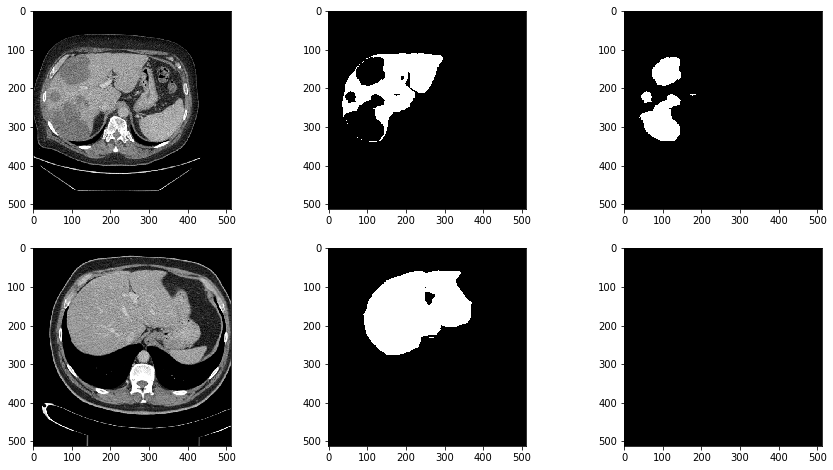

In [0]:
print_input_batch(IMAGE_LIB_TRAIN, MASK_LIB_TRAIN)

In [0]:
#@title Config training {display-mode: "form"}

# TensorBoardColabCallback(tbc),

# Define callbacks that act at the end of epoch

model_names = os.path.join(log_file_path, '{epoch:02d}.hdf5')
model_checkpoint = ModelCheckpoint(model_names, 'val_dice_coef', verbose=2, save_best_only=False, mode='max', save_weights_only=True)

# weight_saver = ModelCheckpoint(weightsPath, monitor='val_dice_coef', 
#                                               save_best_only=True, mode='max', save_weights_only=True)

lr_scd = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

early_stopping = EarlyStopping(monitor='val_dice_coef', mode='max', patience=5)


steps_per_epoch_train =  numOfFiles_train//batchSize # this ensures all data are trained upon in one epoch
steps_per_epoch_val = numOfFiles_val//batchSize # this ensures all data are trained upon in one epoch


In [0]:
hist = model.fit_generator(my_generator(IMAGE_LIB_TRAIN, MASK_LIB_TRAIN, do_resize=False), # Training data supplied by generator
                           steps_per_epoch = steps_per_epoch_train, # Number of mini-batches to run in one epoch
                           validation_data = my_generator(IMAGE_LIB_VAL, MASK_LIB_VAL, do_resize=False),# Validation data
                           validation_steps = steps_per_epoch_val,
                           initial_epoch = initial_epoch,
                           epochs = numOfEpochs,
                           verbose = 2,
                           callbacks = [model_checkpoint, lr_scd, csv_logger])
#                            callbacks = [weight_saver, lr_scd, TensorBoardColabCallback(tbc)])
#                            callbacks = [weight_saver, early_stopping, lr_scd])


Epoch 1/1
Found 500 images belonging to 1 classes.
Found 1092 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 1092 images belonging to 1 classes.
 - 461s - loss: -2.0176e-01 - dice_coef: 0.2018 - precision: 0.1176 - val_loss: -5.7349e-01 - val_dice_coef: 0.5735 - val_precision: 0.4957

Epoch 00001: saving model to /content/gdrive/My Drive/Liver_Segmentation/logs/2Channels/01.hdf5


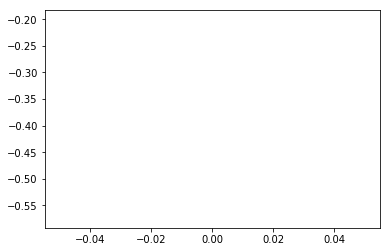

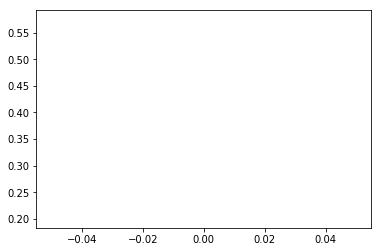

In [0]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['dice_coef'], color='b')
plt.plot(hist.history['val_dice_coef'], color='r')
plt.show()